In [43]:
# Reseteamos todas las variables del entorno
%reset

# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## **CONFIGURACION DEL ENTORNO**

Configuramos el entorno para que nos deje acceder a los archivos e importar los módulos de python.

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import sys  
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'

if GPATH + '/SpeechEmotionRecognition' in sys.path:
  sys.path.remove(GPATH + '/SpeechEmotionRecognition')

sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

## **1. DATOS**

In [47]:

FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'

# Datasets
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'
RAVDESS_PATH = GPATH + 'data/RAVDESS/'

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}

### **1.1 CARGA DE LOS DATOS**

#### **1.1.1 DATASET SAVEE**

In [48]:
# Leemos SAVEE

emotion=[]
path = []

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    path.append(str_path)
    if(filename[0]=='a'):
        emotion.append("angry")
    elif(filename[0]=='h'):
        emotion.append("happy")
    elif(filename[0]=='f'):
        emotion.append("fear")
    elif(filename[0]=='d'):
        emotion.append("disgust")
    elif(filename[0]=='n'):
        emotion.append('neutral')
    elif(filename[0]=='s'):
        if(filename[1]=='a'):
            emotion.append("sad")
        elif(filename[1]=='u'):
            emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [49]:
SAVEE_df.sample(5)

,emotion,path
62,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...
234,surprise,/content/drive/My Drive/Master/Asignaturas/2 C...
183,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...
24,disgust,/content/drive/My Drive/Master/Asignaturas/2 C...
41,disgust,/content/drive/My Drive/Master/Asignaturas/2 C...


### **1.2 DATASET TESS**

In [50]:
# Leemos TESS

emotion=[]
path = []

for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)
    path.append(str_path)
    emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

TESS_df.sample(5)

,emotion,path
1047,angry,/content/drive/My Drive/Master/Asignaturas/2 C...
1754,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
116,sad,/content/drive/My Drive/Master/Asignaturas/2 C...
568,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
2698,surprise,/content/drive/My Drive/Master/Asignaturas/2 C...


In [51]:
TESS_df['emotion'].unique()

array(['sad', 'fear', 'happy', 'neutral', 'angry', 'disgust', 'surprise'],
      dtype=object)

### **1.3 RAVDESS**

In [52]:
emotion = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in os.listdir(RAVDESS_PATH):
  path_dir = os.listdir(RAVDESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    str_path = RAVDESS_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)


# Construimos el data frame
RAVDESS_df = pd.DataFrame(columns=['emotion', 'path'])
RAVDESS_df['emotion'] = emotion
RAVDESS_df['path'] = path
RAVDESS_df['emotion'] = RAVDESS_df['emotion'].map(EMOTION_MAP) 

RAVDESS_df.sample(5)

,emotion,path
825,fear,/content/drive/My Drive/Master/Asignaturas/2 C...
975,calm,/content/drive/My Drive/Master/Asignaturas/2 C...
319,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
758,fear,/content/drive/My Drive/Master/Asignaturas/2 C...
623,sad,/content/drive/My Drive/Master/Asignaturas/2 C...


In [53]:
print( "Size of the dataset: {} \n".format(len(RAVDESS_df)) )
print( RAVDESS_df['emotion'].value_counts() )

Size of the dataset: 1440 

surprise    192
angry       192
sad         192
disgust     192
fear        192
calm        192
happy       192
neutral      96
Name: emotion, dtype: int64


Para que todas las emociones coincidan con el resto de datasets, vamos a eliminar calm

In [54]:
RAVDESS_df['emotion'].unique()
RAVDESS_df = RAVDESS_df[RAVDESS_df['emotion'] != 'calm']
RAVDESS_df['emotion'].unique()

array(['neutral', 'happy', 'sad', 'angry', 'fear', 'surprise', 'disgust'],
      dtype=object)

### **1.2 EXTRACCION DE CARACTERISTICAS**

In [55]:
from src.MFCC import MFCC
# # df_data, dataset_name, outpath='', n_features=40
# featuresMFCC_SAVEE = MFCC(df_data = SAVEE_df)
# featuresSAVEE_standard, featuresSAVEE_wn, featuresSAVEE_shiftted, featuresSAVEE_pitch = featuresMFCC_SAVEE.read_features_dataAugmentation()

In [56]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_SAVEE.pkl' and 
                      features_path + 'featuresMFCC_wn_SAVEE.pkl' and 
                      features_path +'featuresMFCC_shiftted_SAVEE.pk' and 
                      features_path + 'featuresMFCC_pitch_SAVEE.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = 'SAVEE', outpath = features_path)
  featuresSAVEE_standard, featuresSAVEE_wn, featuresSAVEE_shiftted, featuresSAVEE_pitch = featuresMFCC_SAVEE.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_pitch = pickle.load(f)

In [57]:
# Concatenamos con las clases
datasetSAVEE = pd.concat([SAVEE_df.emotion, pd.DataFrame(featuresSAVEE_standard['data'].values.tolist())],axis=1)
datasetSAVEE.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,angry,-268.415161,102.647194,-6.831020,21.777452,5.504901,2.677995,-17.891163,-4.412988,-3.229257,0.431965,-0.299165,-2.524848,-0.071857,-4.558034,5.516014,2.072710,-1.574175,-0.609725,-5.144129,-3.185401,-1.633157,-1.973433,-0.073229,-2.811360,-0.021867,0.143352,0.961058,1.967452,-0.008761,-0.017257,-1.543826,0.943443,-0.501338,-0.080925,0.131035,-1.918740,1.268646,2.679410,2.754247,3.670862
1,angry,-244.658691,104.249260,0.657433,41.458733,-1.098887,3.049911,-23.316795,-7.371824,-7.313964,-5.459171,-5.131516,-6.225185,0.600989,-3.874696,3.832613,-0.631364,1.173085,-0.016179,-6.350923,-3.178102,-1.378558,-3.167055,0.234321,-3.861040,-3.318711,-0.789949,-0.051503,4.036880,2.849089,3.908473,2.513106,4.278307,4.096043,2.962423,3.240562,0.578125,1.794270,3.656604,4.363981,3.638849
2,angry,-457.141174,116.235977,36.340252,37.334404,2.328947,10.415856,-8.627520,-7.653417,1.220687,1.685766,2.807936,4.826628,1.932658,0.788597,8.819584,2.063912,2.408954,5.167501,-0.885871,-0.219375,1.186609,1.849909,1.388026,-2.331348,0.435481,-0.512867,0.410653,0.251607,-0.025797,1.957222,-0.307779,0.934475,-0.475870,1.687494,2.125605,-0.359137,1.364770,2.144406,3.085626,3.569379
3,angry,-441.442596,123.601067,31.101675,47.328548,10.899825,2.156022,-23.183657,-0.154049,6.429157,-0.867114,-0.026879,-0.301824,1.041199,1.111201,11.766346,1.339256,-0.321349,6.915440,-1.305079,-0.159503,2.926197,0.255705,-0.101505,-2.642427,1.411443,-1.501623,-2.327403,0.010480,-0.730455,-0.337589,-1.373045,1.433707,-0.835213,1.011121,2.115383,1.603536,2.301774,1.726071,3.415561,3.127162
4,angry,-423.768341,120.783394,34.300705,42.939449,13.812046,5.338738,-15.809108,-8.547617,0.258116,-1.198904,-0.056940,-1.199689,0.371676,2.397501,10.340876,4.918323,0.812542,1.260555,-0.975449,0.881763,3.192188,2.732885,-1.294272,-2.020182,0.421686,-2.112548,-1.400463,-1.662408,-2.011160,1.610833,0.020815,1.006315,0.947063,0.939697,1.956713,0.167548,1.582842,1.981372,1.343701,3.107995


In [58]:
# Comprobamos las dimensiones
print("SAVEE tiene {} filas y {} caracteristicas".format(datasetSAVEE.shape[0], datasetSAVEE.shape[1]-1))

SAVEE tiene 480 filas y 40 caracteristicas


In [59]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_TESS.pkl' and 
                      features_path + 'featuresMFCC_wn_TESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_TESS.pk' and 
                      features_path + 'featuresMFCC_pitch_TESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = 'TESS', outpath = features_path)
  featuresTESS_standard, featuresTESS_wn, featuresTESS_shiftted, featuresTESS_pitch = featuresMFCC_TESS.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_TESS.pkl', 'rb') as f:
    featuresTESS_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_TESS.pkl', 'rb') as f:
    featuresTESS_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_TESS.pkl', 'rb') as f:
    featuresTESS_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_TESS.pkl', 'rb') as f:
    featuresTESS_pitch = pickle.load(f)

In [60]:
# Concatenamos con sus clases
datasetTESS = pd.concat([TESS_df.emotion, pd.DataFrame(featuresTESS_standard['data'].values.tolist())],axis=1)
datasetTESS.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,sad,-551.718140,93.898018,32.626316,27.400211,12.044376,15.325372,-4.534317,4.946284,-14.656589,1.937302,-14.233812,0.943044,-12.615483,3.372640,-0.877842,-1.540113,-0.692189,3.532070,1.489519,-3.923512,0.486482,-1.894393,-5.936152,2.481138,-3.375456,0.295575,-0.353550,1.325829,-0.575355,5.283757,8.826845,11.738833,9.708747,6.377355,6.265841,-0.755742,4.269774,8.935454,10.005108,9.995243
1,sad,-531.651428,77.865715,21.592104,24.727236,13.807357,15.917933,-21.148481,-13.770829,-17.578056,9.696571,-17.848701,8.055055,-7.135981,7.949358,-1.761927,-3.226586,1.244170,4.245619,0.758662,-7.251886,6.438428,-2.463238,-4.401299,-2.140193,-7.621655,-0.759195,-2.392330,1.330557,0.698337,10.117504,9.391307,11.811658,9.762551,6.464757,6.648894,7.559505,13.014347,17.321518,13.843499,11.259350
2,sad,-531.661011,88.863670,22.462118,14.307739,4.722463,16.334551,-12.150962,-6.318793,-16.228617,8.226312,-14.295836,8.363665,-6.634265,7.822025,0.173369,-4.222826,1.851476,-1.332733,3.747557,-5.150695,2.784880,-1.588107,-3.999930,-1.678870,-5.183728,-2.521509,-0.700438,0.491303,3.090086,8.333586,8.776573,15.926026,8.943348,8.824706,7.321424,4.367829,8.087577,11.370471,11.962422,10.727288
3,sad,-522.041809,91.776588,19.694820,17.102062,11.354354,19.801527,-13.455955,-1.803107,-17.500757,8.322419,-9.423943,8.468165,-10.703864,9.016160,1.094632,-0.321197,-2.890823,1.664478,1.425657,-4.482934,4.417860,-0.164495,-1.783508,0.374725,-6.631550,-0.903343,-0.849893,-2.352705,-0.136731,4.557228,2.842457,6.175436,7.279067,6.246282,6.711571,7.504138,10.784807,9.553627,13.613013,12.409982
4,sad,-545.571716,85.695435,18.834126,16.661682,11.217333,20.650980,-17.235056,-5.440574,-15.194061,7.648641,-12.644619,10.207687,-7.900646,13.539824,4.379575,-2.528398,-0.271885,0.412722,3.764827,-4.015184,3.465311,1.757986,-3.507556,0.300384,-7.395374,-0.800573,1.438032,-0.300767,-1.518672,8.657275,6.702784,10.508049,10.961506,9.439588,6.391417,5.840333,9.162661,7.313199,13.629085,11.613296


In [61]:
print("TESS tiene {} filas y {} caracteristicas".format(datasetTESS.shape[0], datasetTESS.shape[1]-1))

TESS tiene 2800 filas y 40 caracteristicas


In [62]:
features_path = FEATURES_PATH 
if not os.path.exists(features_path + 'featuresMFCC_standard_RAVDESS.pkl' and 
                      features_path + 'featuresMFCC_wn_RAVDESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_RAVDESS.pk' and 
                      features_path + 'featuresMFCC_pitch_RAVDESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC = MFCC(df_data = RAVDESS_df, dataset_name = "RAVDESS", outpath = features_path)
  featuresRAVDESS_standard_, featuresRAVDESS_wn_, featuresRAVDESS_shiftted_, featuresRAVDESS_pitch_ = featuresMFCC.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_standard_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_wn_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_shiftted_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_RAVDESS.pkl', 'rb') as f:
    featuresRAVDESS_pitch_ = pickle.load(f)

In [63]:
# Concatenamos con sus clases
datasetRAVDESS = pd.concat([RAVDESS_df.emotion, pd.DataFrame(featuresRAVDESS_standard_['data'].values.tolist())],axis=1)
datasetRAVDESS.head()

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,neutral,-687.513367,59.441540,-0.703714,16.645708,3.730826,6.181194,-4.576474,-4.167900,-12.985401,-0.837521,-0.999947,0.475966,-1.216027,-1.215597,-2.475016,2.975028,-5.302113,-1.280602,-0.677087,-0.190724,-5.100803,-1.708139,-1.390693,-2.707768,-1.956124,-1.171310,-3.915795,-0.306849,-1.826756,0.107834,-2.024173,-2.586191,-2.420420,-3.243219,-2.762588,-1.960003,-0.453891,-2.976707,-2.914763,-3.909605
1,neutral,-737.635132,75.560745,-0.719248,18.717581,4.626381,6.345685,-7.913329,1.132612,-9.967860,-1.058235,-0.993484,2.756514,-2.520924,-1.648005,-1.561165,1.944345,-3.015163,-1.644124,-1.030529,1.506221,-7.249397,0.076192,-2.584864,-4.161002,-1.586145,-1.232922,-2.754666,0.397765,-2.617944,-0.522748,-2.812648,-3.633809,-3.053499,-2.879167,-4.523717,-0.313282,-2.087159,-3.237412,-4.037536,-4.003767
2,neutral,-695.557861,59.240154,-5.372777,19.776367,5.200387,3.324630,-4.668406,-2.193975,-14.508076,1.307903,-1.574360,-0.464897,-0.916443,-1.577705,-1.585977,1.653715,-5.540579,-0.149309,-2.588039,1.025367,-5.798389,-0.668351,-2.089330,-4.728383,-0.538264,-1.822570,-4.568168,1.003033,-1.973518,-0.205220,-1.055913,-3.102513,-1.697880,-2.922661,-2.544465,-1.289832,-0.797254,-3.586074,-2.706395,-2.812933
3,neutral,-729.980164,66.515892,-0.941984,19.070974,4.297080,5.635081,-6.752989,-0.470559,-12.775139,-2.057870,-1.512891,-0.856074,-1.428092,-1.566959,-1.865984,2.800123,-6.441576,0.045527,-1.760089,-1.149377,-4.876323,-1.231204,-2.686672,-4.453561,-1.473841,-1.516107,-4.421833,0.905688,-2.561618,0.007625,-1.519869,-1.797157,-1.296814,-3.051892,-1.131349,-1.063672,-1.141021,-2.373389,-3.204345,-3.363192
4,NaN,-701.648193,73.041389,-3.148732,17.866001,4.322560,5.934957,-4.265156,-2.297860,-11.038410,-1.490939,-1.626664,0.661111,-0.484398,-1.788267,-0.924487,2.464804,-6.485558,-1.046692,-1.049571,-0.617197,-6.576479,-1.412238,-2.321255,-2.199376,-2.328284,-0.947342,-3.966457,-0.262585,-3.356953,-0.444839,-2.940771,-2.292238,-1.674364,-3.187426,-2.925244,-2.374242,-0.633166,-2.946773,-2.913152,-3.923706


In [64]:
def split_training_test(df, n_splits_=1, test_size_=0.25, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  Aguments
  ---------
  Return
  -------
  '''
  X = df.drop(['emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=42)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento.
  https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
  Aguments
  ---------
  Return
  -------
  '''
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  Aguments
  ---------
  Return
  -------
  '''
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))


  return x_train_norm, y_train, x_test_norm, y_test, label_encoder


def dataset_splitted(dataframe):
  '''
  Devuelve el dataset divido en entrenamiento y test

  '''
  X_train, X_test, Y_train, Y_test = data_process(dataframe)

  return X_train, X_test, Y_train, Y_test




def data_process(features_df):
  '''
  Devuelve el conjunto de datos divido en entrenamiento test procesado correctamente

  '''
  # Division entre entrenamiento y test
  _X_train, _X_test, _Y_train, _Y_test =split_training_test(features_df) 

  # 2. Normaliza los datos
  x_train_norm, x_test_norm = data_normalization(_X_train, _X_test)
  # print(x_train_female_norm.shape)

  # 3. Categorización
  _X_train, Y_train, _X_test, Y_test, labels = data_to_categorical(x_train_norm, _Y_train, x_test_norm, _Y_test)
  # print(labels_female.classes_)

  # 4. Cambio de Dimensión
  X_train = np.expand_dims(_X_train, axis=2)
  X_test = np.expand_dims(_X_test, axis=2)

  return X_train, X_test, Y_train, Y_test

In [65]:
def model_A(data, n_clases):
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same',input_shape=(data.shape[1], 1)))  # X_train.shape[1] = No. of Columns
  model.add(Activation('relu'))

  # model.add(Conv1D(256, 8, padding='same'))
  # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  # model.add(Dropout(0.25))
  # model.add(MaxPooling1D(pool_size=(8)))

  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))
  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))

  # model.add(Conv1D(128, 8, padding='same'))
  # model.add(Activation('relu'))

  model.add(Conv1D(128, 8, padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(MaxPooling1D(pool_size=(8)))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))

  model.add(Conv1D(64, 8, padding='same'))
  model.add(Activation('relu'))

  model.add(Flatten())

  model.add(Dense(n_clases)) # Target class number
  model.add(Activation('softmax'))
  # opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model



def model_B(data, n_classes): # Este es mi modelo antiguo probado n x 10000 veces en RAVDESS
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(data.shape[1],1),
                   activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

  return model


In [66]:
def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')

### **PRUEBA 1: RAVDESS + TESS**

In [67]:
ravdess_tess_dataset = datasetRAVDESS.append(datasetTESS, ignore_index=True)
ravdess_tess_dataset = shuffle(ravdess_tess_dataset)
print("El nuevo dataframe tiene {} filas".format(len(ravdess_tess_dataset)))
ravdess_tess_dataset.head()

El nuevo dataframe tiene 4240 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
213,angry,-478.245270,16.109562,-30.715336,3.216151,-15.184307,-12.782324,-14.174128,-12.969505,-13.750132,-2.633757,-11.918693,-2.920615,-3.544572,14.373567,5.396996,13.453758,4.435157,0.794556,-3.432470,1.022457,-3.706954,-0.647746,-3.494773,0.136740,-0.159241,0.964808,-1.431291,3.763357,3.064794,-1.286016,-4.234253,1.425615,0.588943,0.452640,-2.307928,1.606515,-0.795669,-1.072109,-0.453316,0.599581
3331,fear,-457.048004,66.731979,-0.961549,4.913927,-3.291426,5.235843,-16.965214,4.386679,-19.800175,3.600282,-22.603764,-1.391612,-8.577518,2.365432,-2.610515,4.220601,-3.221427,9.873690,1.452214,3.356511,13.164177,16.600212,10.993501,22.037615,10.229261,12.175020,4.728579,9.378393,-0.170436,4.230065,-2.725755,-0.285134,-1.708924,1.288254,2.147875,2.212283,1.264007,-0.673481,0.455083,-0.854366
1787,fear,-314.533173,37.758915,-20.732777,13.615258,-20.744261,6.174038,-11.158625,-2.572349,-10.600985,8.689822,-20.754992,16.048262,-11.927462,8.781279,-2.640749,-2.790357,2.996115,8.794027,-5.107707,16.499084,4.116069,5.349977,-0.229011,-0.169449,1.064150,5.158766,1.501942,1.585739,-1.789315,-0.455317,-1.736763,2.996043,-3.681550,-0.777441,0.461953,1.382686,2.245384,3.007131,2.274440,1.395018
3475,disgust,-461.517944,85.021553,15.098241,3.242874,7.307648,10.749105,-19.759176,10.356924,-20.911684,6.829238,-8.179501,3.505600,-3.765592,3.933138,-3.744313,0.882662,-3.069010,4.577609,-1.850687,-1.152547,1.683784,-5.749586,-1.585800,-2.529661,-0.224082,4.231915,-1.475196,3.280235,0.838906,2.457260,3.503961,2.466341,3.496413,5.445432,5.854525,7.824049,7.834712,8.720698,11.414384,8.341430
2309,neutral,-374.537720,67.224182,-17.485312,32.795204,-7.553428,2.482320,-12.150448,-3.014596,-10.928593,12.254701,-21.204994,10.701076,-6.801454,5.142638,-0.348108,-6.475689,0.802420,-0.238546,-12.852025,2.746181,-7.069910,-5.332324,-5.485919,-5.559357,-4.942545,-4.016294,-4.208338,1.051312,-5.407701,-2.334926,-10.107509,-5.217864,-0.865987,7.696271,20.676296,32.121166,34.438183,24.524073,11.759235,-1.260218


In [68]:
ravdess_tess_dataset = ravdess_tess_dataset.dropna()
print(ravdess_tess_dataset['emotion'].value_counts())

surprise    592
angry       592
sad         592
disgust     592
fear        592
happy       592
neutral     496
Name: emotion, dtype: int64


In [69]:
X_train, X_test, Y_train, Y_test = dataset_splitted(ravdess_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))


Dimensiones del conjunto de entrenamiento. Datos: (3036, 40, 1) y clases: (3036, 7)
Dimensiones del conjunto de test. Datos: (1012, 40, 1) y clases: (1012, 7)


Probamos con modelo A

In [70]:
modelA = model_A(X_train, Y_train.shape[1])
model_history=modelA.fit(X_train, Y_train, 
                        batch_size=32, 
                        epochs=100, 
                        validation_data=(X_test, Y_test))

Epoch 1/100
95/95 [==============================] - 11s 96ms/step - loss: 1.1683 - accuracy: 0.5750 - val_loss: 1.2437 - val_accuracy: 0.6838
Epoch 2/100
95/95 [==============================] - 8s 89ms/step - loss: 0.6444 - accuracy: 0.7564 - val_loss: 0.9666 - val_accuracy: 0.7016
Epoch 3/100
95/95 [==============================] - 8s 89ms/step - loss: 0.5922 - accuracy: 0.7683 - val_loss: 0.6745 - val_accuracy: 0.7549
Epoch 4/100
95/95 [==============================] - 8s 89ms/step - loss: 0.5636 - accuracy: 0.7765 - val_loss: 0.6345 - val_accuracy: 0.7569
Epoch 5/100
95/95 [==============================] - 9s 90ms/step - loss: 0.5598 - accuracy: 0.7717 - val_loss: 0.6374 - val_accuracy: 0.7401
Epoch 6/100
95/95 [==============================] - 8s 88ms/step - loss: 0.5557 - accuracy: 0.7781 - val_loss: 0.6656 - val_accuracy: 0.7292
Epoch 7/100
95/95 [==============================] - 8s 89ms/step - loss: 0.5266 - accuracy: 0.7833 - val_loss: 0.6025 - val_accuracy: 0.7609
Epoch

32/32 [==============================] - 1s 17ms/step - loss: 1.4592 - accuracy: 0.7717
Loss: 1.4592102766036987 
Accuracy: 77.173912525177%


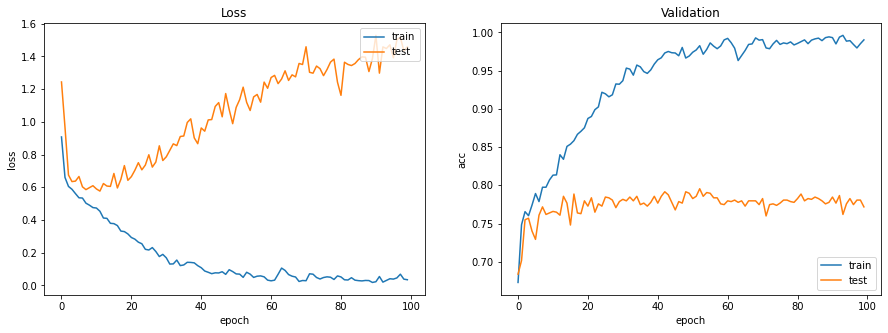

In [71]:
plot_loss_acc(model_history)
# Evaluamos contra test
score = modelA.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

In [72]:
# import sklearn.metrics as metrics

# test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)
# predictions = classifier.predict_generator(test_set, steps=test_steps_per_epoch)
# predicted_classes = np.argmax(predictions, axis=1)

# true_classes = test_set.classes
# class_labels = list(test_set.class_indices.keys())

# report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)

Probamos con modelo B

In [73]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
95/95 [==============================] - 3s 19ms/step - loss: 2.9089 - accuracy: 0.2317 - val_loss: 2.4888 - val_accuracy: 0.4891
Epoch 2/100
95/95 [==============================] - 1s 13ms/step - loss: 2.4674 - accuracy: 0.4442 - val_loss: 2.2925 - val_accuracy: 0.5929
Epoch 3/100
95/95 [==============================] - 1s 13ms/step - loss: 2.2469 - accuracy: 0.5295 - val_loss: 2.1440 - val_accuracy: 0.5949
Epoch 4/100
95/95 [==============================] - 1s 13ms/step - loss: 2.0925 - accuracy: 0.5613 - val_loss: 2.0279 - val_accuracy: 0.6077
Epoch 5/100
95/95 [==============================] - 1s 12ms/step - loss: 1.9568 - accuracy: 0.5829 - val_loss: 1.9367 - val_accuracy: 0.6383
Epoch 6/100
95/95 [==============================] - 1s 13ms/step - loss: 1.8661 - accuracy: 0.5831 - val_loss: 1.8578 - val_accuracy: 0.6630
Epoch 7/100
95/95 [==============================] - 1s 13ms/step - loss: 1.7758 - accuracy: 0.6180 - val_loss: 1.7922 - val_accuracy: 0.6354
Epoch 

32/32 [==============================] - 0s 4ms/step - loss: 1.0411 - accuracy: 0.7322
Loss: 1.0410618782043457 
Accuracy: 73.22134375572205%


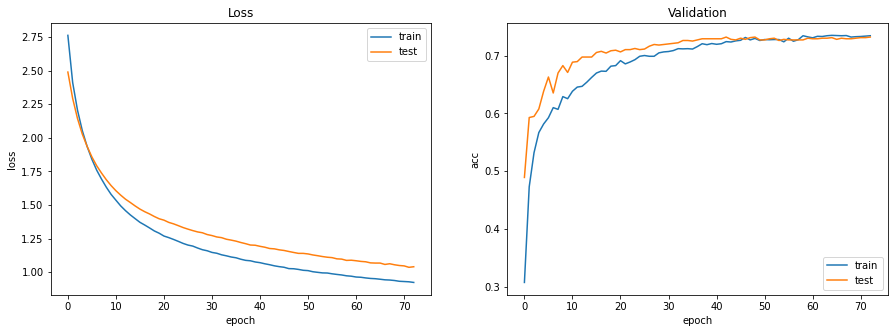

In [74]:
plot_loss_acc(model_history1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **PRUEBA 2: TESS + SAVEE**

In [75]:
savee_tess_dataset = datasetSAVEE.append(datasetTESS, ignore_index=True)
savee_tess_dataset = shuffle(savee_tess_dataset)
print("El nuevo dataframe tiene {} filas".format(len(savee_tess_dataset)))
savee_tess_dataset.head()

El nuevo dataframe tiene 3280 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
352,surprise,-320.564911,110.933815,12.457850,34.670757,11.628866,-2.938115,-24.859945,-2.633692,-0.919507,-11.532021,-2.435335,-0.981383,-0.914500,-1.698188,5.144086,0.517353,-3.503025,5.504008,-0.994490,-5.816047,0.016101,0.534374,1.778036,-2.088270,-1.304948,-3.518475,-4.197404,-0.128658,-1.990220,0.656227,1.452810,1.783171,3.263025,2.756852,3.496058,5.099578,4.885279,5.633801,4.365917,3.453820
2918,surprise,-490.953979,99.064873,3.796988,-10.696701,-1.883562,20.005131,-22.357126,-7.470296,-21.487665,2.697214,-8.187195,-7.614591,-0.310620,4.593921,-3.264925,0.921962,0.541357,10.101417,6.152111,2.569910,2.171681,1.902395,2.972939,7.730654,2.563290,6.515897,5.877280,6.929472,3.355731,4.567449,3.261737,8.429317,13.881192,10.114227,14.685185,4.556870,6.249557,2.822585,1.728105,3.639221
1512,angry,-306.679840,76.657570,-11.072245,10.588560,-12.353613,5.280250,-1.921970,-26.179033,-9.954917,11.081635,-23.622925,18.948130,-17.436237,6.665927,-4.775308,-5.769747,-5.714253,-0.254398,-13.361215,-1.678910,-3.772812,-2.743578,-3.229925,-3.553171,1.815767,3.619147,12.068581,14.380793,18.502743,12.007950,2.941936,2.810747,-2.793222,3.134155,6.023759,4.141313,0.994626,-1.046848,-1.829924,0.054385
2997,surprise,-433.394623,92.638153,9.116809,-0.123955,-9.138528,3.751444,-12.850397,10.032985,-22.885817,7.349143,-14.995247,0.147273,-5.803288,6.225860,-6.434320,7.700333,-4.337691,10.989993,2.651472,-1.520123,-0.332019,3.532420,-2.322448,3.056282,-1.317858,3.985101,-1.171064,5.581912,-2.187975,4.029406,2.051383,0.962369,2.577234,0.120487,3.500504,3.735918,6.991288,9.706486,11.327210,9.408649
2016,neutral,-503.435638,90.846672,9.873958,9.318667,9.510436,15.040021,-23.517822,-4.668269,-18.753424,2.070402,-16.208668,3.438377,-13.603551,9.602702,5.242227,3.837937,-5.579204,8.974141,-1.611816,-2.997247,1.094266,1.219829,-1.028848,-0.367624,-11.429762,-4.867609,-3.885233,-0.122890,-2.659028,-1.866631,-6.727105,-6.245818,-7.249397,5.262687,21.006666,29.283585,40.240910,35.581848,22.915010,7.077095


In [76]:
savee_tess_dataset = savee_tess_dataset.dropna()
print(savee_tess_dataset['emotion'].value_counts())

neutral     520
surprise    460
angry       460
sad         460
disgust     460
fear        460
happy       460
Name: emotion, dtype: int64


In [77]:
X_train, X_test, Y_train, Y_test = dataset_splitted(savee_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (2460, 40, 1) y clases: (2460, 7)
Dimensiones del conjunto de test. Datos: (820, 40, 1) y clases: (820, 7)


Probamos el modelo A

In [78]:
model = model_A(X_train, Y_train.shape[1])
model_history2 = model.fit(X_train, Y_train, 
                        batch_size=32, 
                        epochs=100, 
                        validation_data=(X_test, Y_test))

Epoch 1/100
77/77 [==============================] - 9s 95ms/step - loss: 0.8502 - accuracy: 0.7183 - val_loss: 1.1104 - val_accuracy: 0.7378
Epoch 2/100
77/77 [==============================] - 7s 87ms/step - loss: 0.3743 - accuracy: 0.8615 - val_loss: 0.6759 - val_accuracy: 0.8415
Epoch 3/100
77/77 [==============================] - 7s 87ms/step - loss: 0.3089 - accuracy: 0.8805 - val_loss: 0.4199 - val_accuracy: 0.8610
Epoch 4/100
77/77 [==============================] - 7s 88ms/step - loss: 0.3099 - accuracy: 0.8798 - val_loss: 0.3442 - val_accuracy: 0.8756
Epoch 5/100
77/77 [==============================] - 7s 88ms/step - loss: 0.2918 - accuracy: 0.8894 - val_loss: 0.3437 - val_accuracy: 0.8720
Epoch 6/100
77/77 [==============================] - 7s 88ms/step - loss: 0.2680 - accuracy: 0.8922 - val_loss: 0.3205 - val_accuracy: 0.8793
Epoch 7/100
77/77 [==============================] - 7s 88ms/step - loss: 0.2605 - accuracy: 0.8983 - val_loss: 0.3291 - val_accuracy: 0.8732
Epoch 

52/52 [==============================] - 1s 10ms/step - loss: 0.8535 - accuracy: 0.8756
Loss: 0.8534604907035828 
Accuracy: 87.56097555160522%


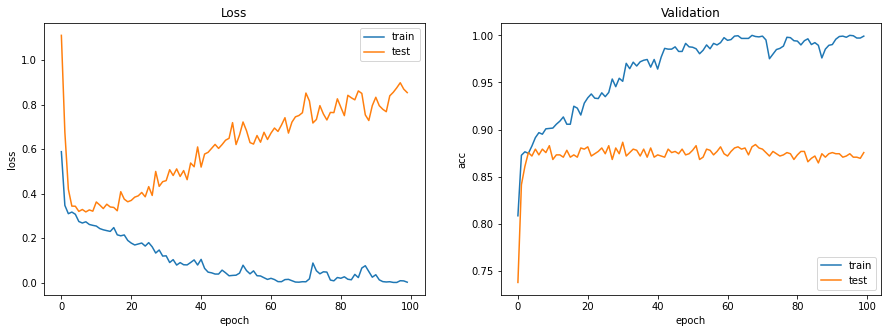

In [79]:
plot_loss_acc(model_history2)
# Evaluamos contra test
score = model.evaluate(X_test, Y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

Probamos el modelo B

In [80]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history2_1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
77/77 [==============================] - 3s 19ms/step - loss: 2.7990 - accuracy: 0.2626 - val_loss: 2.4526 - val_accuracy: 0.5817
Epoch 2/100
77/77 [==============================] - 1s 13ms/step - loss: 2.4174 - accuracy: 0.5012 - val_loss: 2.2708 - val_accuracy: 0.6280
Epoch 3/100
77/77 [==============================] - 1s 13ms/step - loss: 2.2051 - accuracy: 0.5890 - val_loss: 2.1246 - val_accuracy: 0.6634
Epoch 4/100
77/77 [==============================] - 1s 13ms/step - loss: 2.0520 - accuracy: 0.6294 - val_loss: 2.0072 - val_accuracy: 0.7256
Epoch 5/100
77/77 [==============================] - 1s 14ms/step - loss: 1.9144 - accuracy: 0.6756 - val_loss: 1.9048 - val_accuracy: 0.7244
Epoch 6/100
77/77 [==============================] - 1s 13ms/step - loss: 1.7988 - accuracy: 0.6958 - val_loss: 1.8192 - val_accuracy: 0.7402
Epoch 7/100
77/77 [==============================] - 1s 13ms/step - loss: 1.7211 - accuracy: 0.7262 - val_loss: 1.7489 - val_accuracy: 0.7634
Epoch 

26/26 [==============================] - 0s 4ms/step - loss: 0.7183 - accuracy: 0.8646
Loss: 0.7182664275169373 
Accuracy: 86.46341562271118%


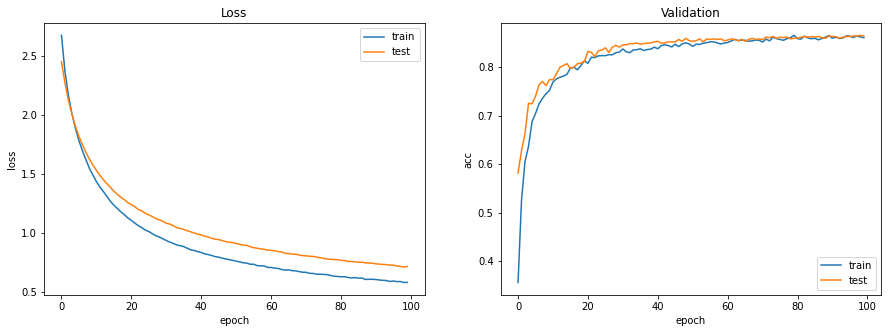

In [81]:
plot_loss_acc(model_history2_1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **PRUEBA RAVDESS + TESS + SAVEE**

In [82]:
# datasetRAVDESS
ravdess_savee_tess_dataset = savee_tess_dataset.append(datasetRAVDESS, ignore_index=True)
print("El nuevo dataframe tiene {} filas".format(len(ravdess_savee_tess_dataset)))
ravdess_savee_tess_dataset = shuffle(ravdess_savee_tess_dataset)
ravdess_savee_tess_dataset.head()

El nuevo dataframe tiene 4720 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
4707,fear,-585.601196,43.378284,-24.321405,9.750392,-18.808237,-7.804722,-16.941601,-13.697145,-10.970797,-3.173166,-12.592230,1.402280,-7.102910,-5.759763,-1.822240,-6.773964,-4.688128,-2.879968,-5.949895,-2.013481,-4.809864,-3.899276,-5.805748,-4.097223,-4.147200,-0.882811,-0.012867,5.988527,4.993007,6.218528,2.956265,1.461940,1.413392,3.337905,3.339135,3.194121,2.785244,1.096110,1.282149,1.706047
3752,surprise,-556.956543,52.215199,-13.353804,12.630665,-4.977727,3.842434,-4.489671,-11.185124,-6.607677,4.890848,-7.319613,-3.060084,-3.160757,4.523212,-1.917320,3.346644,0.316070,5.605220,3.046896,7.404449,1.172725,5.836874,2.216411,5.614178,2.613019,5.166980,3.466976,3.558331,2.281046,2.809242,1.306731,3.058989,3.253778,2.822761,3.298396,3.404967,3.054217,3.574030,3.674679,3.141717
3992,disgust,-558.302002,56.608784,-20.167578,13.516650,-6.068489,-2.262799,-15.234907,-8.724503,-7.246281,6.826088,-13.219136,-0.420770,-7.597297,-1.527265,-6.794344,-5.558316,-5.966490,-0.775373,-4.631419,-0.039684,2.034786,1.657002,0.007650,2.124870,-1.399715,4.233812,-0.734050,3.970155,3.954983,6.364359,4.283607,3.677219,1.651869,2.459601,1.135491,1.815530,3.778378,1.438973,2.604829,1.613233
3612,sad,-383.231140,24.325399,-41.019573,-1.426841,-16.419079,-13.692386,-8.119010,-9.750441,-14.866369,3.448282,-13.567456,2.197678,4.773283,16.620035,11.563853,8.181790,-2.829799,-6.249601,-2.570315,1.975309,3.721194,-4.156753,-6.103728,0.918694,5.536469,2.991129,1.296537,6.088335,2.698370,-1.140212,-2.600618,4.667205,2.245387,1.099582,0.366415,2.653480,-0.093867,2.879913,4.381723,0.728644
4141,happy,-544.083313,68.699539,-16.442411,19.895182,11.452861,-0.667652,-2.127572,5.392642,-9.443252,5.018168,0.624261,3.524324,-1.820204,3.654942,0.968743,1.429048,0.858079,-0.706671,1.490508,1.783044,-1.201087,1.127499,-1.164101,1.581873,-1.767681,1.188254,-0.856072,0.999697,-1.622420,1.564103,-0.569695,-1.253781,-0.087603,-0.617627,-0.629738,1.818401,2.023069,1.272829,1.843886,-0.991177


In [83]:
ravdess_savee_tess_dataset = ravdess_savee_tess_dataset.dropna()
print(ravdess_savee_tess_dataset['emotion'].value_counts())

surprise    652
angry       652
sad         652
disgust     652
fear        652
happy       652
neutral     616
Name: emotion, dtype: int64


In [84]:
X_train, X_test, Y_train, Y_test = dataset_splitted(ravdess_savee_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (3396, 40, 1) y clases: (3396, 7)
Dimensiones del conjunto de test. Datos: (1132, 40, 1) y clases: (1132, 7)


Probamos con el modelo A

In [85]:
modelA = model_A(X_train, Y_train.shape[1])
model_history3 = modelA.fit(X_train, Y_train, 
                        batch_size=32, 
                        epochs=100, 
                        validation_data=(X_test, Y_test))

Epoch 1/100
107/107 [==============================] - 12s 91ms/step - loss: 1.2029 - accuracy: 0.5725 - val_loss: 1.3130 - val_accuracy: 0.5892
Epoch 2/100
107/107 [==============================] - 9s 85ms/step - loss: 0.8461 - accuracy: 0.6917 - val_loss: 0.9247 - val_accuracy: 0.6855
Epoch 3/100
107/107 [==============================] - 9s 85ms/step - loss: 0.7408 - accuracy: 0.7209 - val_loss: 0.8372 - val_accuracy: 0.6731
Epoch 4/100
107/107 [==============================] - 9s 85ms/step - loss: 0.7411 - accuracy: 0.7073 - val_loss: 0.7944 - val_accuracy: 0.6749
Epoch 5/100
107/107 [==============================] - 9s 86ms/step - loss: 0.6862 - accuracy: 0.7331 - val_loss: 0.7745 - val_accuracy: 0.6882
Epoch 6/100
107/107 [==============================] - 9s 86ms/step - loss: 0.7006 - accuracy: 0.7244 - val_loss: 0.7727 - val_accuracy: 0.6873
Epoch 7/100
107/107 [==============================] - 9s 86ms/step - loss: 0.6754 - accuracy: 0.7324 - val_loss: 0.7582 - val_accuracy

71/71 [==============================] - 1s 10ms/step - loss: 1.7721 - accuracy: 0.6988
Loss: 1.772124171257019 
Accuracy: 69.87632513046265%


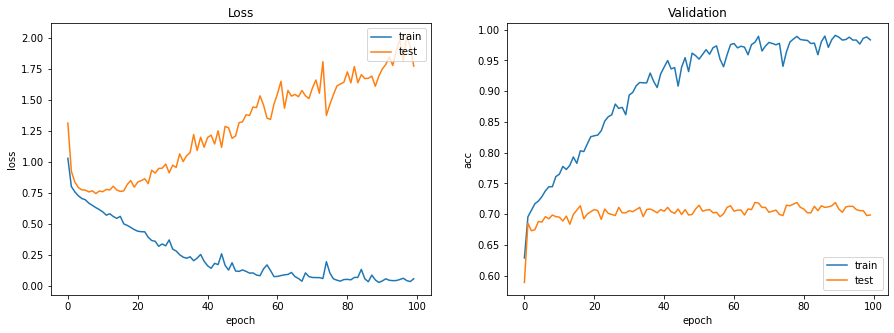

In [86]:
plot_loss_acc(model_history3)
# Evaluamos contra test
score = modelA.evaluate(X_test, Y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

Probamos el modelo B

In [87]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history3_1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
107/107 [==============================] - 3s 18ms/step - loss: 2.8628 - accuracy: 0.2582 - val_loss: 2.4618 - val_accuracy: 0.3604
Epoch 2/100
107/107 [==============================] - 1s 13ms/step - loss: 2.4525 - accuracy: 0.3996 - val_loss: 2.2837 - val_accuracy: 0.4859
Epoch 3/100
107/107 [==============================] - 1s 13ms/step - loss: 2.2329 - accuracy: 0.4625 - val_loss: 2.1513 - val_accuracy: 0.4991
Epoch 4/100
107/107 [==============================] - 1s 13ms/step - loss: 2.0970 - accuracy: 0.5017 - val_loss: 2.0453 - val_accuracy: 0.5212
Epoch 5/100
107/107 [==============================] - 1s 13ms/step - loss: 1.9702 - accuracy: 0.5191 - val_loss: 1.9625 - val_accuracy: 0.5353
Epoch 6/100
107/107 [==============================] - 1s 13ms/step - loss: 1.8874 - accuracy: 0.5348 - val_loss: 1.8889 - val_accuracy: 0.5398
Epoch 7/100
107/107 [==============================] - 1s 13ms/step - loss: 1.7894 - accuracy: 0.5609 - val_loss: 1.8328 - val_accuracy:

36/36 [==============================] - 0s 3ms/step - loss: 1.1318 - accuracy: 0.6581
Loss: 1.1317698955535889 
Accuracy: 65.81271886825562%


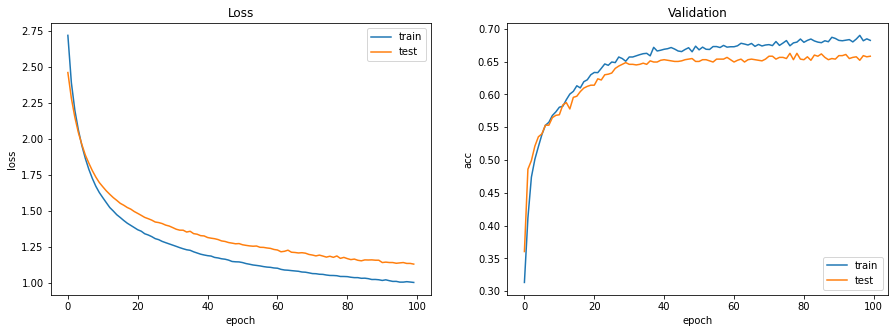

In [88]:
plot_loss_acc(model_history3_1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))